## Image Processing - scc0251

# Image Enhancement and Filtering

This notebook has some examples of 3 ways to use filters to enhance images

### Some useful function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [2]:
def padding_image(input_img, filter_size):
    adjustment=int(np.floor(filter_size/2))
    return np.pad(input_img,pad_width=adjustment,mode='constant')

In [3]:
def normalization(img):
    m = img.min()
    M = img.max()
    return (((img-m)*255.0)/(M-m))


In [4]:
def gaussian_kernel(sigma, x):
    return (1/(2*np.pi*(sigma**2)))*(np.e**(-1*((x**2)/(2*(sigma**2)))))

In [5]:
def convolution(img, f):
    #output image
    out_img = np.zeros(img.shape)
    
    #fliping the filter in 
    f_flip = np.flip(np.flip(f,0),1)
    
    #getting the dimensios of the filter
    f_n,f_m = f.shape
    
    a = int((f_n-1)/2) 
    b = int((f_m-1)/2)
    
    #padding the image and getting its dimensions
    pd_img = padding_image(img, f_n)
    pd_img_n,pd_img_m = pd_img.shape
    
    for x in range(a, (pd_img_n-a)):
        for y in range(b, (pd_img_m - b)):
            
            img_region = pd_img[ (x-a):(x+(a+1)) , (y-b) : (y+(b+1))]

            out_img[(x-a),(y-b)] = np.sum(np.multiply(img_region, f_flip))
            
    return out_img

In [6]:
def euclidian_distance(x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**(0.5)

In [7]:
def spatial_gaussian_component(sigma,size):
    filter = np.zeros((size,size))
    a = int(size/2)
    for i in range(0,size):
        for j in range(0,size):
            filter[i][j] = gaussian_kernel(sigma,euclidian_distance(i-a,j-a,0,0))
    return filter


def range_gaussian_component(img,sigma,size,x,y):
    range_gaussian = np.zeros((size,size))
    center_intensity = img[x][y]
    a = int(size/2)
    neighbor_intensities = img[x-a:x+a+1,y-a:y+a+1]
    range_gaussian = gaussian_kernel(sigma,neighbor_intensities.astype(np.float64)-float(center_intensity))
    return range_gaussian

In [8]:
def vignette(img, sigma1, sigma2):
    n, m = img.shape

    #crating the tow 1D kernels
    gauss_row = np.zeros((n, 1), dtype = float)
    gauss_col = np.zeros((1, m), dtype = float)

    #calculating the kernels' center
    a = int((n-1)/2)
    b = int((m-1)/2)

    #calculating the values
    for i in range(0, n):
        gauss_row[i,0] = gaussian_kernel(sigma1, i-a)

    for i in range(0, m):
        gauss_col[0,i] = gaussian_kernel(sigma2, i-b)

    #multiplying the tow arrays to creatr a gaussian matrix
    f = np.matmul(gauss_row , gauss_col)

    #multiplying the original image by the filter
    img_out = np.multiply(img, f)

    return img_out

In [9]:
def bilateral_filter(input_img, spatial_gaussian,sigma_r):

    input_img = input_img.astype(np.float64)

    #output image
    out_img = np.zeros(input_img.shape)


    #getting the dimensios of the filter
    filter_size = spatial_gaussian.shape[0]

    fa = int((filter_size-1)/2)

    #padding the image and getting its dimensions
    pd_img = padding_image(input_img, filter_size)
    pd_img_n,pd_img_m = pd_img.shape


    for x in range(fa, (pd_img_n-fa)):
        for y in range(fa, (pd_img_m - fa)):
            final_intensity, wp = [0,0]
            range_gaussian = range_gaussian_component(pd_img,sigma_r,filter_size,x,y)
            w_filter = spatial_gaussian * range_gaussian
            wp = np.sum(w_filter)
            img_region = pd_img[ x-fa:x+(fa+1), y-fa:y+(fa+1)]
            final_intensity = np.sum(np.multiply(img_region, w_filter))
            out_img[(x-fa),(y-fa)] = final_intensity/wp
    return out_img


## Method 1 - Bilateral Filter

The bilateral filter is a nonlinear filtering technique to smooth images while preserving edges

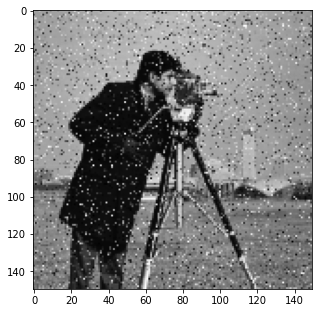

In [20]:
img1 = imageio.imread("images/camera.png")

plt.figure(figsize =(11, 11))
plt.subplot(121)
plt.imshow(img1, cmap="gray", vmin= 0, vmax=255)

In [24]:
img_f = bilateral_filter(img1,spatial_gaussian_component(150.0,3),100.0)

(-0.5, 149.5, 149.5, -0.5)

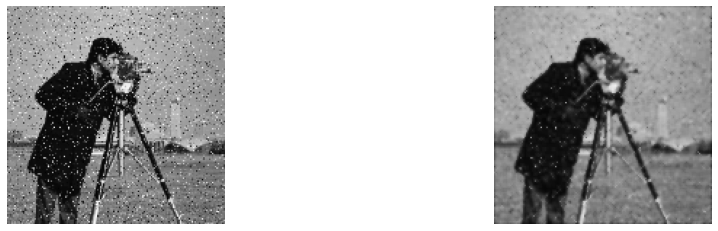

In [25]:
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(122)
plt.imshow(img_f, cmap="gray", vmin=0, vmax=255)
plt.axis('off')


## Method 2 - Unsharp Mask using the Laplacian Filter

Sharpening is an operation that tries to enhance edges and transitions of intensities. The
unsharp mask filtering is a sharpening technique that subtracts an unsharp or blurred
version of an image from the original image.

In [13]:
f = np.matrix([[0,-1,0], [-1,4,-1], [0,-1,0]])
g = np.matrix([[-1,-1,-1], [-1,4,-1], [-1,-1,-1]])
print(f)
print(g)

[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]
[[-1 -1 -1]
 [-1  4 -1]
 [-1 -1 -1]]


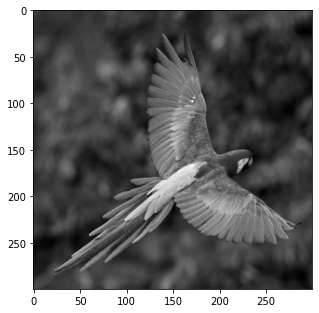

In [14]:
img1 = imageio.imread("images/arara.png")

plt.figure(figsize =(11, 11))
plt.subplot(121)
plt.imshow(img1, cmap="gray", vmin= 0, vmax=255)

In [15]:
img2 = convolution(img1, f)
img3 = normalization(img2)
img4 =((img3*0.5) + img1)
img_fim = normalization(img4)

(-0.5, 299.5, 299.5, -0.5)

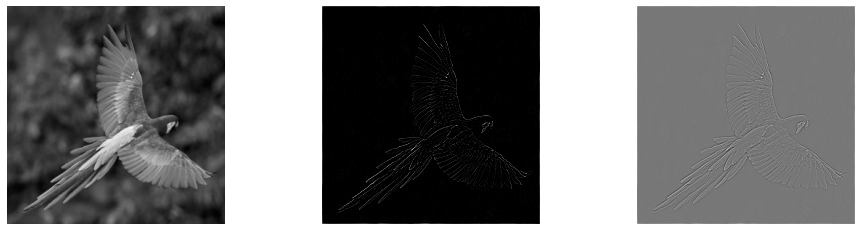

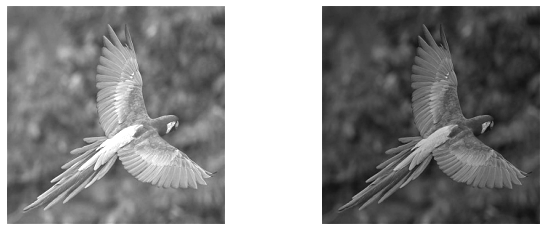

In [16]:
plt.figure(figsize=(16,4))

plt.subplot(131)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(img3, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.figure(figsize=(16,4))

plt.subplot(131)
plt.imshow(img4, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(img_fim, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

## Method 3 - Vignette Filter

The vignette filter consists in a gaussian centred in the image, with different valuesof standard deviation.  It causes the effect of vignetting, which reduces the image’sbrightness towards the image corners, compared to the center.

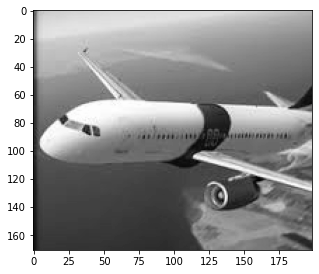

In [17]:
img = imageio.imread("images/airplane.png")
plt.figure(figsize =(11, 11))
plt.subplot(121)
plt.imshow(img, cmap="gray", vmin= 0, vmax=255)

In [18]:
img_aux = vignette(img,30,45)
img_f   = normalization(img_aux)

(-0.5, 198.5, 170.5, -0.5)

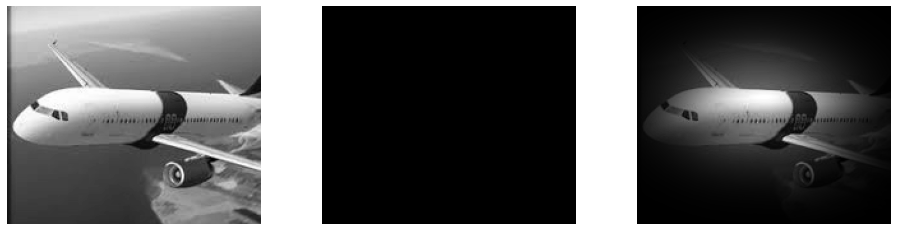

In [19]:
plt.figure(figsize=(16,4))

plt.subplot(131)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(img_aux, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(img_f, cmap="gray", vmin=0, vmax=255)
plt.axis('off')